In [1]:
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf

In [2]:
data = pd.read_csv("UCF-crime-frames-descriptions-partitions.csv")

In [3]:
data.head(2)

,Unnamed: 0,frame,directory,class,Description,partition
0,0,Abuse001_x264.mp4_frame_000000.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train
1,1,Abuse001_x264.mp4_frame_000010.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train


In [4]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]
test = data.loc[data["partition"] == "test"]

In [5]:
labels = {"Normal": 0,
          "Abuse": 1,
          "Arrest": 2,
          "Arson": 3,
          "Burglary": 4,
          "Explosion": 5,
          "Fighting": 6,
          "RoadAccidents": 7,
          "Shooting": 8,
          "Vandalism": 9
         }

In [6]:
V = np.load( "val.npy")

In [7]:
y_val = list(val["class"])
y_val = np.array([labels[lbl] for lbl in y_val])
V.shape, y_val.shape

((19330, 1408), (19330,))

In [8]:
X = np.load("train.npy")

In [9]:
y = list(train["class"])
y = np.array([labels[lbl] for lbl in y])
X.shape, y.shape

((124145, 1408), (124145,))

In [84]:
m, M, mean = tf.reduce_min(X), tf.reduce_max(X), tf.reduce_mean(X)
X = (X-mean)/(M-m)
V = (V-mean)/(M-m)

In [26]:
_, _, counts = tf.unique_with_counts(y)
counts

<tf.Tensor: shape=(10,), dtype=int32, numpy=
array([84684,  2593,   689, 10454,  4984,  8211,  2138,  2646,  6178,
        1568])>

In [30]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [31]:
class_weight_dict = dict(enumerate(weights))

In [23]:
model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(1408,)))
model.add(Dropout(0.4))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation="softmax"))

In [24]:
optimizer = Adam(learning_rate=.00001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [25]:
history = model.fit(X, y, 
                    validation_data=(V, y_val), 
                    #class_weight=class_weight_dict, 
                    epochs=10, 
                    batch_size=64)

Epoch 1/10
1940/1940 [==============================] - 9s 4ms/step - loss: 1.2337 - accuracy: 0.6679 - val_loss: 1.1538 - val_accuracy: 0.6680
Epoch 2/10
1940/1940 [==============================] - 8s 4ms/step - loss: 0.8937 - accuracy: 0.7350 - val_loss: 1.0639 - val_accuracy: 0.6868
Epoch 3/10
1940/1940 [==============================] - 8s 4ms/step - loss: 0.7423 - accuracy: 0.7710 - val_loss: 1.0123 - val_accuracy: 0.6787
Epoch 4/10
1940/1940 [==============================] - 8s 4ms/step - loss: 0.6434 - accuracy: 0.7974 - val_loss: 0.9925 - val_accuracy: 0.6660
Epoch 5/10
1940/1940 [==============================] - 7s 4ms/step - loss: 0.5715 - accuracy: 0.8161 - val_loss: 0.9925 - val_accuracy: 0.6485
Epoch 6/10
1940/1940 [==============================] - 7s 4ms/step - loss: 0.5165 - accuracy: 0.8315 - val_loss: 0.9924 - val_accuracy: 0.6517
Epoch 7/10
1940/1940 [==============================] - 7s 4ms/step - loss: 0.4761 - accuracy: 0.8420 - val_loss: 0.9944 - val_accuracy:

In [26]:
val_pred = model.predict(V)

In [27]:
print(classification_report(y_val, tf.argmax(val_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78     12895
           1       0.34      0.32      0.33       646
           2       0.65      0.13      0.22      1321
           3       0.31      0.73      0.44       106
           4       0.25      0.24      0.24      1767
           5       1.00      0.80      0.89       388
           6       0.78      0.13      0.22      1132
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        44
           9       0.11      0.01      0.01      1019

    accuracy                           0.65     19330
   macro avg       0.41      0.32      0.31     19330
weighted avg       0.62      0.65      0.60     19330



C:\Users\msubr\Anaconda3\envs\tf28\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msubr\Anaconda3\envs\tf28\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msubr\Anaconda3\envs\tf28\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [29]:
CLASS_LABELS = ["normal", 
                "Abuse",
                "Arrest",
                "Arson",
                "Burglary",
                "Explosion",
                "Fighting",
                "RoadAccidents",
                "Shooting",
                "Vandalism"]

def multiclass_roc_auc_score(y_true, y_pred, average="macro"):    
    y_true = tf.keras.utils.to_categorical(y_true, dtype='float32')
    
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_true[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_true, y_pred, average=average)

ROC AUC score: 0.8124688284212933


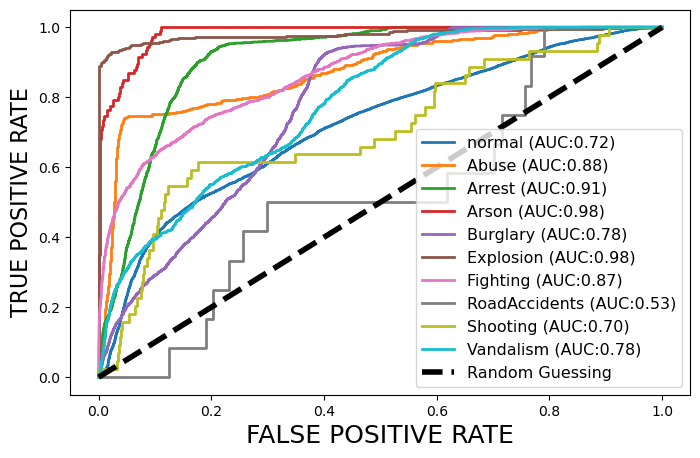

In [31]:
fig, c_ax = plt.subplots(1,1, figsize = (8,5))

print('ROC AUC score:', multiclass_roc_auc_score(y_val , val_pred, average = "macro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [32]:
y_pred = model.predict(X)

In [33]:
print(classification_report(y, tf.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     84684
           1       0.66      0.65      0.65      2593
           2       0.88      0.97      0.92     10454
           3       0.83      0.93      0.88      4984
           4       0.84      0.96      0.90      8211
           5       0.75      0.83      0.79      2138
           6       0.78      0.82      0.80      6178
           7       1.00      0.02      0.04       689
           8       0.82      0.13      0.22      1568
           9       0.75      0.74      0.75      2646

    accuracy                           0.90    124145
   macro avg       0.82      0.70      0.69    124145
weighted avg       0.90      0.90      0.89    124145



ROC AUC score: 0.9946156445013026


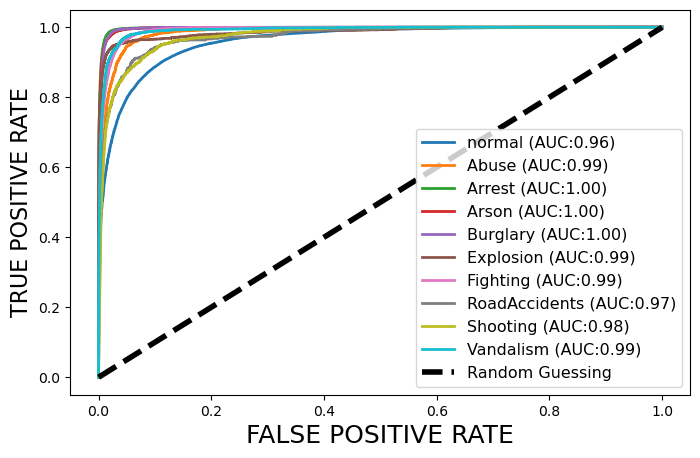

In [34]:
fig, c_ax = plt.subplots(1,1, figsize = (8,5))



print('ROC AUC score:', multiclass_roc_auc_score(y , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()